# Solving the [8-puzzle](https://8-puzzle.readthedocs.io/en/latest/) (with a slight twist)
## Heuristic search vs uninformed search, admissibility, performance tests, empirical results, and some charts! Fun stuff ahead


Instead of only being able to slide tiles vertically and horizontally (with a cost of 1), when the empty tile is at a corner, the tiles on the same row (or on the same column) can wrap around (if you have more than two rows) with a cost of 2. Similarly the diagonal tiles (both the adjacent one and the opposing corner) can slide into an empty corner with a cost of 3. We use the number 0 to represent the empty tile.

In [19]:
# you need to install these in your env to run this notebook
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import copy

# local modules, no installs needed
from board import Board
from node import Node
import search
from heuristics import hamming_distance, manhattan_distance, row_col_out_of_place, euclidean_distance, permutation_inversion



We have implemented a bunch of heuristics, but we don't know which are the best for our problem. We know from theory that hamming distance and manhattan distance are both [admissible](https://en.wikipedia.org/wiki/Admissible_heuristic) and that permutation inversion is not. But we came up with two new heuristics and would like to know about their admissibility.


1. Rows and columns out of place: 

    Is the sum of all tiles that are out of their goal row position and all tiles that are out of their goal column position. For example, if a tile is out of both row and column position it adds 2 to the running sum of the heuristic, if it's out of row XOR column it adds 1 to the sum and if the tile is in its goal position it add 0 to the heuristic sum. We expect it to be admissible because when conceptually compared with hamming and manhattan distance, this heuristic seems to be more optimistic than manhattan distance but slightly less optimistic than hamming distance. It s more optimistic than manhattan because it essentially three states: either in place, out of place along one axis or out of place along two axis. Manhattan will assign more add more estimated cost to tiles that are further away from their goal position, making it less optimistic than this heuristic.

2. Euclidean distance:

    Is the sum of the euclidean distances between each tile and it's goal position. Euclidean distance should be more optimistic than manhattan distance for the following reason: given any two coordinates on the board manhattan distance calculates the number of steps that the tile has to move but the tile is restricted to moves that are parallel to the x-axis or the y-axis. if you were to take any two tiles and draw the euclidean and manhattan distance between them, you would get a right triangle where the euclidean distance draws the hypothenuse and the manhattan distance draws the opposite and adjacent sides. The hypothenuse is always smaller than the sum of the two other sides, which is why we expect euclidean distance to be admissible.



In order to validate our intuition, we will generate 100 random [8-puzzles](https://8-puzzle.readthedocs.io/en/latest/) in 2x4 and 3x3 format and run algorithms A* and Greedy Best First Search using these heuristics. Of course to verify whether we get the shortest cost solution path to those puzzle we will also run Uniform Cost Search to obtain the shortest paths with certainty.

In [3]:
HEURISTICS = [hamming_distance, manhattan_distance, row_col_out_of_place, euclidean_distance, permutation_inversion]

NUMBER_PUZZLES = 50

two_by_two = [np.random.permutation(8).reshape(2,4) for _ in range(NUMBER_PUZZLES)]

three_by_three = [np.random.permutation(9).reshape(3,3) for _ in range(NUMBER_PUZZLES)]



In [4]:
print(f"Here are the {NUMBER_PUZZLES} random 2x4 puzzles")
for puzzle in two_by_two:
    print(puzzle)

Here are the 50 random 2x4 puzzles
[[3 0 6 5]
 [4 2 1 7]]
[[6 2 5 7]
 [1 4 3 0]]
[[6 2 5 1]
 [4 7 0 3]]
[[2 7 1 6]
 [0 5 4 3]]
[[3 6 0 2]
 [1 5 7 4]]
[[5 2 3 6]
 [0 4 7 1]]
[[2 0 3 6]
 [7 4 5 1]]
[[5 3 0 1]
 [6 2 4 7]]
[[6 5 1 3]
 [0 7 2 4]]
[[1 3 6 5]
 [2 4 0 7]]
[[2 3 0 1]
 [5 6 7 4]]
[[6 1 2 3]
 [5 0 7 4]]
[[5 4 0 6]
 [7 1 3 2]]
[[6 0 3 2]
 [4 7 5 1]]
[[2 1 7 5]
 [0 3 4 6]]
[[4 0 6 5]
 [1 3 2 7]]
[[2 3 5 6]
 [4 0 7 1]]
[[3 0 6 4]
 [2 1 5 7]]
[[1 7 0 2]
 [4 5 6 3]]
[[0 6 2 1]
 [3 4 7 5]]
[[3 1 2 7]
 [6 5 4 0]]
[[1 0 6 2]
 [5 4 7 3]]
[[3 1 4 5]
 [6 0 7 2]]
[[7 4 1 6]
 [2 3 5 0]]
[[7 1 3 0]
 [6 4 2 5]]
[[4 3 7 0]
 [2 5 6 1]]
[[2 3 4 6]
 [5 0 7 1]]
[[1 0 7 3]
 [2 6 4 5]]
[[5 1 2 4]
 [7 0 6 3]]
[[6 4 5 1]
 [2 7 3 0]]
[[5 7 1 2]
 [0 3 4 6]]
[[0 3 1 6]
 [5 2 4 7]]
[[3 4 1 7]
 [0 2 6 5]]
[[4 7 2 6]
 [0 5 3 1]]
[[3 0 7 1]
 [6 5 4 2]]
[[1 7 2 5]
 [0 6 3 4]]
[[1 3 7 0]
 [5 2 6 4]]
[[1 5 6 2]
 [0 3 4 7]]
[[1 7 0 3]
 [4 6 5 2]]
[[3 7 6 5]
 [2 1 0 4]]
[[2 5 6 7]
 [3 0 1 4]]
[[1 5 7 0]
 [6 3 2 4]]

In [5]:
print(f"Here are the {NUMBER_PUZZLES} random 3x3 puzzles")
for puzzle in three_by_three:
    print(puzzle)

Here are the 50 random 3x3 puzzles
[[8 1 7]
 [2 4 3]
 [0 6 5]]
[[4 2 5]
 [6 8 0]
 [3 7 1]]
[[0 8 2]
 [3 6 1]
 [7 5 4]]
[[1 3 5]
 [4 6 0]
 [8 7 2]]
[[4 6 1]
 [7 8 0]
 [5 2 3]]
[[8 0 3]
 [5 7 1]
 [2 6 4]]
[[4 8 6]
 [3 0 2]
 [7 1 5]]
[[1 7 3]
 [2 5 6]
 [4 8 0]]
[[8 5 6]
 [4 2 3]
 [1 7 0]]
[[4 0 1]
 [3 5 2]
 [6 8 7]]
[[4 8 5]
 [6 1 3]
 [0 2 7]]
[[2 0 7]
 [5 1 6]
 [8 4 3]]
[[7 6 0]
 [4 5 3]
 [2 1 8]]
[[8 2 3]
 [4 7 5]
 [6 1 0]]
[[4 6 7]
 [2 8 5]
 [1 0 3]]
[[8 2 1]
 [3 5 4]
 [0 7 6]]
[[5 3 0]
 [2 7 1]
 [4 8 6]]
[[3 5 4]
 [0 7 8]
 [2 1 6]]
[[3 2 6]
 [8 7 5]
 [4 0 1]]
[[7 0 4]
 [1 2 3]
 [8 5 6]]
[[6 4 2]
 [5 1 7]
 [0 8 3]]
[[6 5 2]
 [1 0 3]
 [8 7 4]]
[[5 8 6]
 [4 3 2]
 [7 1 0]]
[[5 7 1]
 [3 2 4]
 [6 8 0]]
[[3 7 5]
 [2 6 0]
 [1 8 4]]
[[8 1 6]
 [0 5 3]
 [2 4 7]]
[[0 4 5]
 [8 2 6]
 [7 3 1]]
[[4 3 5]
 [0 1 6]
 [8 2 7]]
[[2 4 3]
 [7 0 5]
 [8 1 6]]
[[1 6 7]
 [4 8 5]
 [0 2 3]]
[[6 7 4]
 [8 1 3]
 [5 2 0]]
[[3 1 7]
 [5 6 4]
 [0 8 2]]
[[5 4 3]
 [6 0 1]
 [2 8 7]]
[[6 7 8]
 [4 2 1]
 [0 3 5]]
[[5 2 1]
 [0 

In [6]:
def build_experiment_object():
    '''Build's the structure that will run the experiment and hold results'''
    experiment = {}
    for func in HEURISTICS:
        experiment[func.__name__] = {
            'func': func,
            'algos': {
                'GBF': {
                    'func': search.greedy_best_first,
                    'shape': {
                        (2, 4): {'results': []},
                        (3, 3): {'results': []}
                    }
                },
                'A*': {
                    'func': search.a_star,
                    'shape': {
                        (2, 4): {'results': []},
                        (3, 3): {'results': []}
                    }
                }
            },
        }

    return experiment

experiment = build_experiment_object()

In [7]:
def run_experiment(experiment: dict, puzzles: list):
    for heurist_name in tqdm(experiment):
        heuristic_func = experiment[heurist_name]['func']

        for algo_name in experiment[heurist_name]['algos']:
            algo_func = experiment[heurist_name]['algos'][algo_name]['func']

            for puzzle in puzzles:
                b = Board(puzzle)
                result: dict = algo_func(board=b, H=heuristic_func)
                experiment[heurist_name]['algos'][algo_name]['shape'][puzzle.shape]['results'].append(result)

    return experiment

#### Let's Run A* and Greedy Best First search on the 50 2x4 puzzles

In [8]:

print('\nRunning 2 search algorithms on 50 puzzles, 5 different times to test the 5 heuristics:')
start = time.time()

run_experiment(experiment,two_by_two)

elapsed = round(time.time()-start, 2)
print(f'\n\nTotal of 2x50x5 = {2*50*5} puzzles solved in {elapsed} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]
Running 2 search algorithms on 50 puzzles, 5 different times to test the 5 heuristics:
100%|██████████| 5/5 [01:21<00:00, 16.29s/it]

Total of 2x50x5 = 500 puzzles solved in 81.45 seconds



#### Now Let's Run the same algorithms with the same heuristics on the 3x3 puzzles

In [9]:
start = time.time()

run_experiment(experiment, three_by_three)

elapsed = round(time.time()-start, 2)
print(f'\n\nTotal of 2x50x5 = {2*50*5} puzzles solved in {elapsed} seconds')

100%|██████████| 5/5 [05:12<00:00, 62.47s/it]

Total of 2x50x5 = 500 puzzles solved in 312.33 seconds



In [20]:
def generate_stats(experiment):
    prototype = {
        'GBF': {
            'hamming_distance': {},
            'manhattan_distance': {},
            'row_col_out_of_place': {},
            'euclidean_distance': {},
            'permutation_inversion': {}
        },
        'A*': {
            'hamming_distance': {},
            'manhattan_distance': {},
            'row_col_out_of_place': {},
            'euclidean_distance': {},
            'permutation_inversion': {}
        }
    }
    global_stats = {
        (2,4): copy.deepcopy(prototype),
        (3,3): copy.deepcopy(prototype),
        }
    stats = {}
    timeouts = 0
    result_count = 0

    for heuristic in experiment:

        for algo in experiment[heuristic]['algos']:
            
            for shape in experiment[heuristic]['algos'][algo]['shape']:

                results = experiment[heuristic]['algos'][algo]['shape'][shape]['results']
                
                runtimes = [r['runtime'] for r in results]
                costs = np.array([r['current_node'].total_cost for r in results])
                num_visited_nodes = np.array([r['visited_nodes'] for r in results])
                
                mean_runtime = np.mean(runtimes)
                mean_cost = np.mean(costs)
                mean_vis_nodes = np.mean(num_visited_nodes)
                
                global_stats[shape][algo][heuristic]['mean_runtime'] = mean_runtime
                global_stats[shape][algo][heuristic]['mean_cost'] = mean_cost
                global_stats[shape][algo][heuristic]['mean_visited_nodes'] = mean_vis_nodes
                global_stats[shape][algo][heuristic]['std_runtime'] = np.std(runtimes)
                global_stats[shape][algo][heuristic]['std_cost'] = np.std(costs)
                global_stats[shape][algo][heuristic]['std_visited_nodes'] = np.std(num_visited_nodes)
                
                timeouts += len([1 for r in results if not r['success']])
    
    print(f'number of timeouts = {timeouts}.')

    return global_stats


In [30]:
stats = generate_stats(experiment)
'''here is a small sample of what the stats object looks like'''
stats[(2,4)]['GBF']['hamming_distance']

number of timeouts = 0.


{'mean_runtime': 0.0178,
 'mean_cost': 21.66,
 'mean_visited_nodes': 91.14,
 'std_runtime': 0.014041367454774483,
 'std_cost': 8.091007353846615,
 'std_visited_nodes': 75.87200010544075}

We definitely did not expect any timeouts for algorithms A* and GBF as they are designed to be very fast but having the assurance is always nice.

Let us now compare these heuristics.

In [34]:
'''Calculating average runtime for each heuristic'''
def plot_stats(stats, shape, algo):
    
    heuris_vs_runtime = {}
    heuris_vs_cost = {}
    heuris_vs_visited = {}

    for heuristic in stats[shape][algo]:
        alias = stats[shape][algo][heuristic]
        heuris_vs_runtime[heuristic] = round(alias['mean_runtime'], 2)
        heuris_vs_cost[heuristic] = round(alias['mean_cost'], 2) 
        heuris_vs_visited[heuristic] = round(alias['mean_visited_nodes'], 2)
    
    print(heuris_vs_runtime)
    plt.barh(tuple(heuris_vs_runtime.keys()),heuris_vs_runtime.values())
    plt.ylabel('Heuristics')
    plt.xlabel('Time in Seconds')
    plt.title(f'Mean runtime of {algo} on {shape[0]}x{shape[1]} puzzles')
    plt.show()
    print()

    print(heuris_vs_cost)
    plt.barh(tuple(heuris_vs_cost.keys()),heuris_vs_cost.values())
    plt.ylabel('Heuristics')
    plt.xlabel('Cost')
    plt.title(f'Mean cost of {algo} on {shape[0]}x{shape[1]} puzzles')
    plt.show()
    print()
    
    print(heuris_vs_visited)
    plt.barh(tuple(heuris_vs_visited.keys()),heuris_vs_visited.values())
    plt.ylabel('Heuristics')
    plt.xlabel('Number of Visited Nodes')
    plt.title(f'Mean search path of {algo} on {shape[0]}x{shape[1]} puzzles')
    plt.show()


    

{'hamming_distance': 0.24, 'manhattan_distance': 0.1, 'row_col_out_of_place': 0.25, 'euclidean_distance': 0.25, 'permutation_inversion': 0.24}


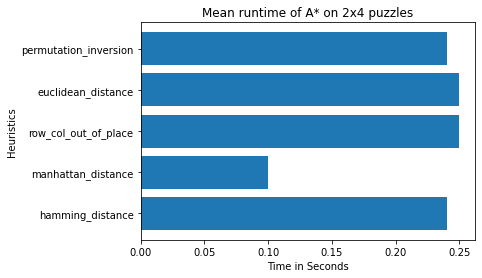


{'hamming_distance': 12.34, 'manhattan_distance': 12.36, 'row_col_out_of_place': 12.32, 'euclidean_distance': 12.28, 'permutation_inversion': 14.52}


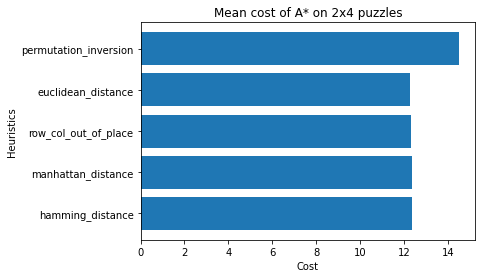


{'hamming_distance': 582.56, 'manhattan_distance': 95.4, 'row_col_out_of_place': 226.48, 'euclidean_distance': 231.52, 'permutation_inversion': 220.14}


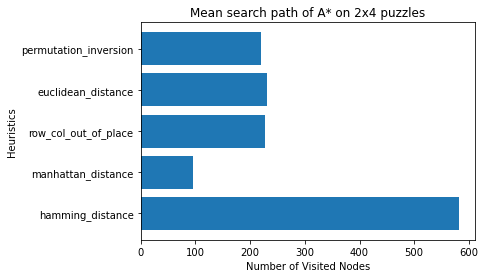

In [35]:
plot_stats(stats,(2,4),'A*')

{'hamming_distance': 0.02, 'manhattan_distance': 0.05, 'row_col_out_of_place': 0.07, 'euclidean_distance': 0.08, 'permutation_inversion': 0.33}


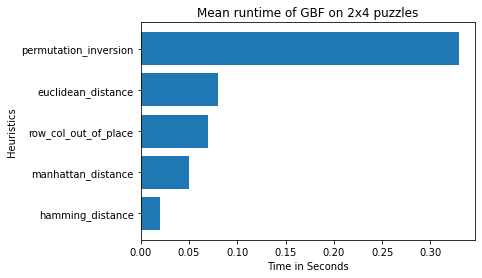


{'hamming_distance': 21.66, 'manhattan_distance': 21.64, 'row_col_out_of_place': 20.78, 'euclidean_distance': 25.44, 'permutation_inversion': 30.64}


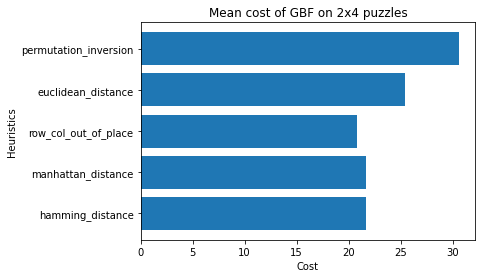


{'hamming_distance': 91.14, 'manhattan_distance': 82.76, 'row_col_out_of_place': 119.12, 'euclidean_distance': 116.76, 'permutation_inversion': 600.8}


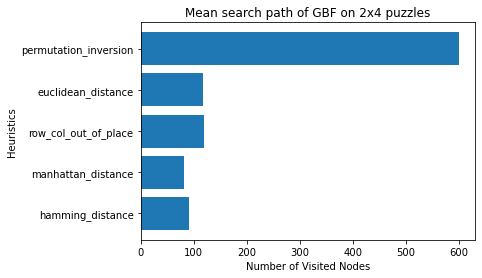

In [36]:
plot_stats(stats,(2,4),'GBF')

{'hamming_distance': 2.01, 'manhattan_distance': 0.26, 'row_col_out_of_place': 0.88, 'euclidean_distance': 1.29, 'permutation_inversion': 0.82}


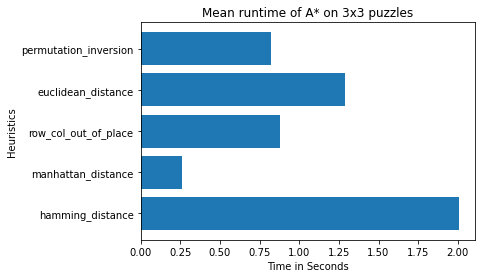


{'hamming_distance': 15.14, 'manhattan_distance': 15.02, 'row_col_out_of_place': 15.18, 'euclidean_distance': 15.02, 'permutation_inversion': 17.62}


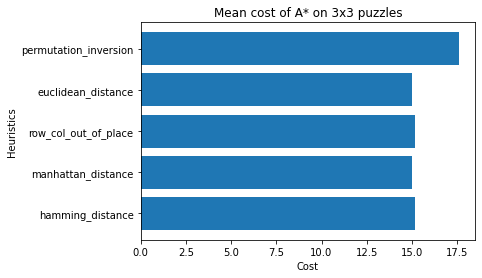


{'hamming_distance': 3734.76, 'manhattan_distance': 205.56, 'row_col_out_of_place': 782.36, 'euclidean_distance': 865.8, 'permutation_inversion': 591.46}


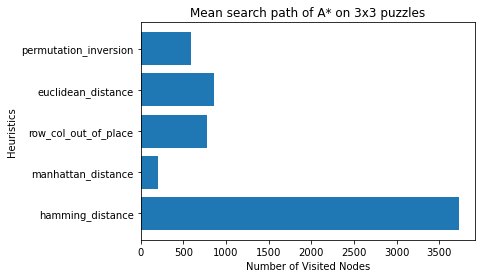

In [37]:
plot_stats(stats,(3,3),'A*')

{'hamming_distance': 0.05, 'manhattan_distance': 0.04, 'row_col_out_of_place': 0.06, 'euclidean_distance': 0.04, 'permutation_inversion': 0.71}


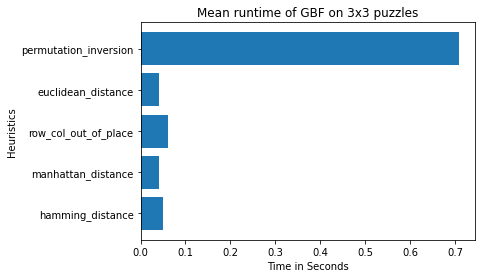


{'hamming_distance': 26.9, 'manhattan_distance': 24.22, 'row_col_out_of_place': 26.24, 'euclidean_distance': 27.0, 'permutation_inversion': 32.44}


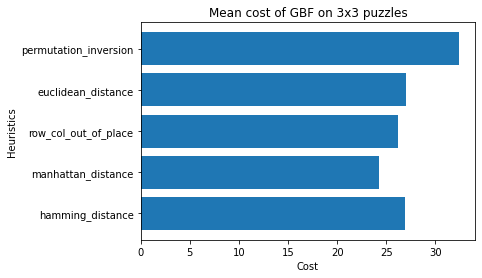


{'hamming_distance': 179.94, 'manhattan_distance': 50.24, 'row_col_out_of_place': 92.98, 'euclidean_distance': 47.84, 'permutation_inversion': 1195.24}


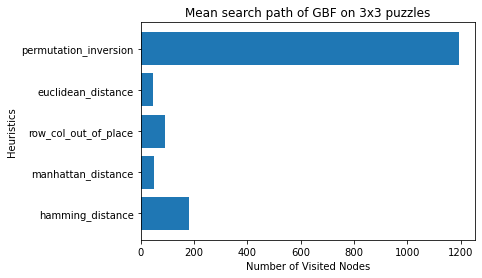

In [38]:
plot_stats(stats,(3,3),'GBF')

## Interpretation of performance, admissibility, and informativeness (i.e how optimal is the search path)

At first look, both heuristics that we implemented are reasonably good. When looking at the charts, good means a smaller bar i.e. smaller execution time, cost, and search path. Both heuristics have a satisfactory combination of all three metrics. If you look at the bar chart for the average cost of A\* you will find that euclidean distance clearly has an average cost <= to manhattan and hamming distances (in theory, they should be exactly equal). This reinforces our intuition that it is an admissible heurisitic. "Row and Column" heuristic seems to have a very slightly higher average cost but the difference is so small that we think it could be caused by slight numerical instabilities more so than anything. After all we know that hamming and manhattan are both admissible yet they don't have the exact same average cost (even though they should in theory). All in all one could safely assume that both of our heuristics are admissible (or at least very very close to being admissible).

Looking at runtime alone is not sufficient for understanding a heuristic. If two heuristics have the same runtime but the first one visits many more nodes, it means that the first heuristic is probably faster to compute but less informative. If two heuristics visit the same number of nodes but one of them is way faster than you can conclude that they have the same informativeness but one is simply faster to compute.

We found that heuristics can perform differently depending on the algorithm. For example, look at how permutation inversion and hamming distance perform on A\* vs GBF. On A\*, hamming visits an order of magnitude more nodes than permutation whereas the exact opposite happens on GBF. Remember that A\* uses F(n) = G(n) + H(n) where G is the cost and H is the heuristic whereas GBF only looks at the value of H(n) to decide on the next state explored. The data suggests that hamming is a bad heuristic to tie break between two states that have a similar cost. On the other hand, hamming seems to be a great heuristic when used as the sole search criterion. The exact opposite happens with permutation inversion. As a stand-alone, it's a bad search criteria but when used to tie-break between nodes that have similar costs, it cuts a large amount of the search space.

All in all, heuristics are a subtle science. Crafting a useful heuristic function is a little bit of science and a little bit of art because it is dependant on your domain. Remember that there does not exist a perfect heuristic. If it did we would not need state-space search to begin with!